# HW 4 - Applied Machine Learning
# Classification

> __TASK 1 __ Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

> __BONUS__: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

## Import packages

In [1]:
# plotting utils
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# data utils
import pandas as pd
import numpy as np
import operator
import seaborn as sns
import random

# from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import metrics

# from helpers.py
from helpers import *

## Import X and y

In [2]:
X, y = load_x_y()

In [3]:
df_agg = pd.read_csv('df_agg.csv', index_col=0)

In [4]:
feature_labels = df_agg.drop('rater', axis=1).columns
feature_labels

Index(['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'position', 'club', 'leagueCountry',
       'firstName'],
      dtype='object')

We also compute standardized and scaled versions of X

In [5]:
# standardized and scaled X
X_standardized = (X-X.mean()) / X.std()
X_scaled = (X-X.min()) / (X.max()-X.min())

Just as a reminder, here is the target __y__ (skin color) distribution :

# 0s (white skin):  1200
# 1s (dark skin):  269


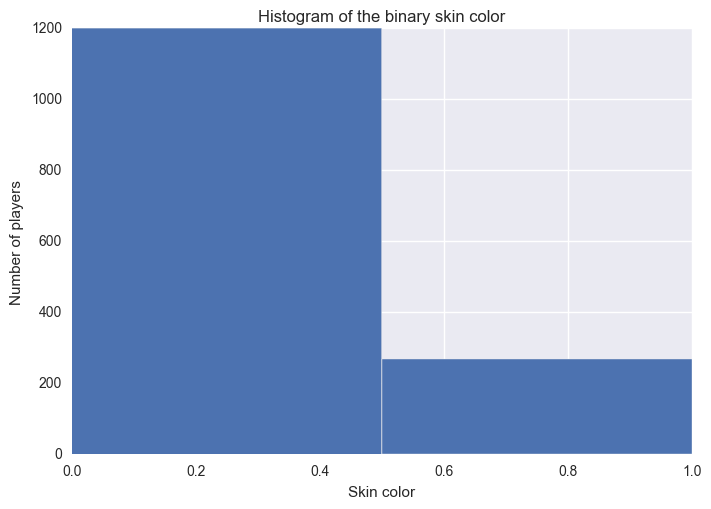

In [6]:
target_names = ['White skin', 'Dark skin']

print("# 0s (white skin): ", df_agg.rater.value_counts()[0])
print("# 1s (dark skin): ", df_agg.rater.value_counts()[1])
f, ax = plt.subplots()
ax.set_title("Histogram of the binary skin color")
ax.set_xlabel("Skin color")
ax.set_ylabel("Number of players")
df_agg.rater.hist(ax=ax, bins=2)

## a) Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color.

Let's train a simple random forest classfier and get the classification score (accuracy) which will be our baseline. 

Split in train and test data first

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=0)

We can now fit a RandomForest Classifier to our train data and apply it to our test data 

In [8]:
rfc_base = RandomForestClassifier()
rfc_base = rfc_base.fit(X=X_train, y=y_train)

y_base_pred = rfc_base.predict(X_test)

Below we can find the accuracy of our classifier :

In [9]:
acc_base = accuracy_score(y_test,y_base_pred)
print("Accuracy: ", acc_base)

Accuracy:  0.850340136054


So the score above is our baseline. 

#### Score metrics choice

We used `accuracy_score()` to evaluate the accuracy of our prediction and got some reasonable score (around 80% of accuracy) but we can wonder if it's actually the right score metrics to evaluate our classifier. Indeed, our `y` is very unbalanced - 1200 white skin labels (0.0) and 269 dark skin labels (1.0) which correspond to 77.58 % of white skin labels. That means using a simple model assigning class 0 all the time would, in expectation, already perform roughly 78% well in accuracy. 

Since the number of dark skin rated players and white skin rated players is unbalanced, we decided not to use the simple accuracy scoring proposed in `sklearn.metrics` or `sklearn.model_selection`. 
We will evaluate the score using __`BACC` (Balanced Accuracy)__. (it will make more sense as a random assignment will lead to 50% BACC now).

Let's evaluate with BACC to see the difference. We also visualize the confusion matrix that enables to display whether we are performing well (diagonal) and where we perform poorly (antidiagonal)

Confusion matrix, without normalization
[[241   9]
 [ 35   9]]


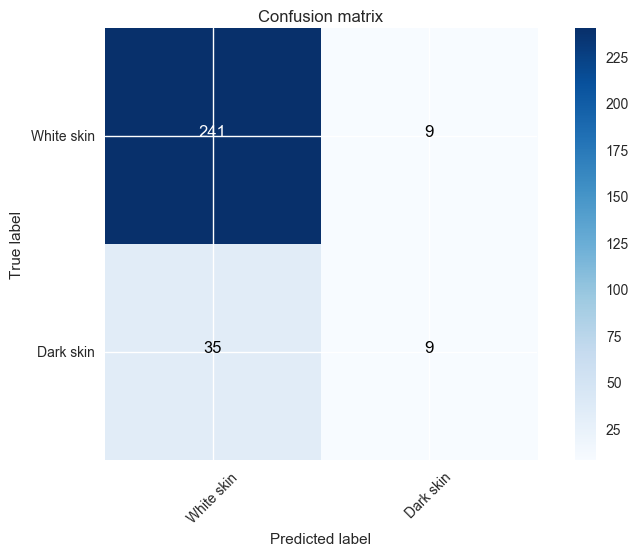

True Neg:  241
True Pos:  9
False Neg:  35
False Pos:  9
Balanced Accuracy:  0.584272727273


In [10]:
cnf_matrix = confusion_matrix(y_test, y_base_pred)
tn, fp, fn, tp = cnf_matrix.ravel()

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix')
plt.show()

print("True Neg: ", tn)
print("True Pos: ", tp)
print("False Neg: ", fn)
print("False Pos: ", fp)

print('Balanced Accuracy: ', BACC(tn,tp,fn,fp))

As we can see from both the confusion matrix and the BACC, our classifier is very bad for now... Indeed we have only 53.4% BACC against 50% for a random, and the confusion matrix shows that we basically miss a lot of dark skin players (assigning them as white skin) - which corresponds to the False Negative prediction.

### Please note, starting from now that we use Balanced Accuray as a measure and not Accuracy, so it is normal we don't reach 80% as maybe other groups do.

---

## b) Show how different parameters passed to the Classifier affect the overfitting issue.

Let's see if some parameters of the Random Forest Classifier have influence on overfitting our data. We'll see that for parameters `n_estimators`, `max_depth` and `max_nodes`.

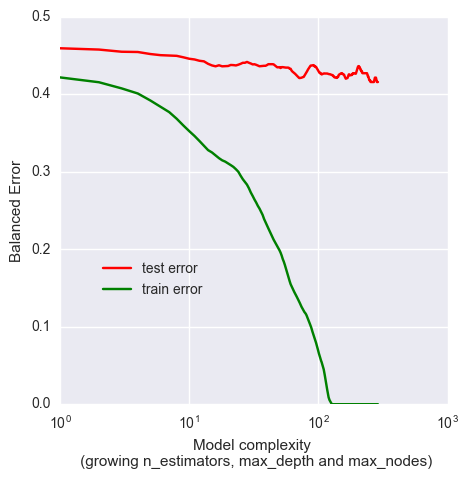

In [11]:
viz_complexity(Xtr=X_train, Xte=X_test, ytr=y_train, yte=y_test,
               estimators_grid=range(1,300), 
               max_depth_grid=range(1,300), 
               max_nodes_grid=range(2,303))

From this visualization we can see that for a growing complexity (we actually grow parameters `n_estimators`, `max_depth` and `max_nodes`) then there is a very particular evolution for both train and test errors. First, train and test errors both decrease, which means that the model is actually learning more and more and reducing the bias, but at some point the test error stops improving and even starts getting worse : the variance is starting to get high and this is typical of __overfitting__. Indeed, the train error ends up to 0 which means we perfectly fit our training data but poorly generalizes so the test error gets worse and worse.

---

## c) Perform cross-validation to mitigate the overfitting of your model. 

### Gridsearch cross validation
Let's use `GridSearchCV()` to find the best hyperparameters for the `RandomForestClassifier` with a cross-validation over 10 folds. We use the function `StratifiedKFold` since the problem exhibits a large imbalance in the distribution of the target classes. By using this function, the folds are made by preserving the percentage of samples for each class.

In [12]:
bacc_scorer = make_scorer(score_BACC, greater_is_better=True)

In [13]:
# Let's create a personalized scoring function to use inside sklearn function.
bacc_scorer = make_scorer(score_BACC, greater_is_better=True)

rfc_GS = RandomForestClassifier(n_estimators=10, max_depth=20, min_samples_split=2, max_leaf_nodes=10, random_state=0)

# Hyperparameter grid
param_grid = { 
    'n_estimators': range(10,35,5),
    'max_depth': range(20,70,10),
    'max_leaf_nodes': range(10,35,5),
    'min_samples_split': range(2,12,2)
}

n_folds = 10
Skf = StratifiedKFold(n_splits=n_folds,shuffle=True, random_state=0)
GSCV_rfc = GridSearchCV(estimator=rfc_GS, param_grid=param_grid, cv=Skf, scoring=bacc_scorer)
GSCV_rfc.fit(X_train, y_train)

print('\nGridSearchCV best params for ', n_folds, ' fold is: ', GSCV_rfc.best_params_)



GridSearchCV best params for  10  fold is:  {'n_estimators': 10, 'max_depth': 20, 'min_samples_split': 2, 'max_leaf_nodes': 30}


So based on the previous founded best parameters, we create a new RF classifier. We fit it first to the train set, compute the validaiton score and finally we predict and evaluate the score on test set.

In [14]:
rfc_tr = RandomForestClassifier(n_estimators=10, max_depth=20, min_samples_split=2, max_leaf_nodes=30, random_state=0)
rfc_tr.fit(X_train, y_train)

Skf_tr = StratifiedKFold(n_splits=10,shuffle=True, random_state=0)
cv_tr_score = cross_val_score(rfc_tr, X_train, y_train, cv=Skf_tr, scoring=bacc_scorer)
te_pred = rfc_tr.predict(X_test)
te_score = score_BACC(y_test, te_pred)


print('The rfc validation score with GridSearchCV() best params for ', 20, ' fold is: ', cv_tr_score.mean())
print('The rfc test score is: ', te_score)

The rfc validation score with GridSearchCV() best params for  20  fold is:  0.55290592929
The rfc test score is:  0.55531496063


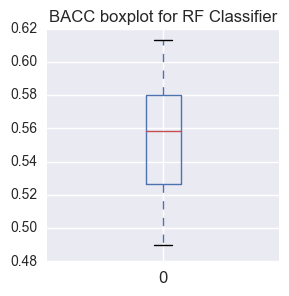

In [15]:
plt.figure(figsize=(3,3))
plt.title("BACC boxplot for RF Classifier")
pd.DataFrame(cv_tr_score).boxplot(return_type="dict");

One can observe that the test score is a little bit better than the baseline (0.532) and relatively the same as the validation score. And ofcourse the *improvement* is not significant enough given the std of our model (see the boxplot).
Our classifier is definitely not good but since finding the best test score is not the main purppose of this homework let's move on to the next part.

---

## d) Once you assessed your model, inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

### Remove features
To observe the different importance of the features, we try two different approaches :  
* From the original features set we remove some of them randomly (20 iterations). We increase also the number to see which one is the most important. 
* We compute the `feature_importances_` and at each iteration we remove the less important feature which cannot be reused again (20 iterations)

To visualize the features importance we use a kind of "heat map" of our DataFrame. We simply ranked for each iteration (=removing) the score obtained with `feature_importances_`. The dark green cells correspond to the important features and the light green cells to less important ones.

In [16]:
df_ = df_agg.drop('rater', axis=1)

list_random = remove_random_features(df_, y)
list_less = remove_less_important(df_,y)

Let's visualize the results for the first approach (random removal). Columns are iterations

In [17]:
viz_random_heatmap(list_random)

We can already have a feeling on which features have high importance (spot the dark green cells) such as `meanExp`, `leagueCountry`... But now when removing at each iteration the less important features (sorting them). Columns are iterations

In [18]:
viz_lessImportant_heatmap(list_less)

We can clearly see that the features `meanEXP`, `leagueCountry`, `nEXP`, are the most important ones for the classification. 

Something interesting to see is that the final ranking we have (actually the index) is not the same as the one we would have had on iteration 1 ! (where `nExp` would have been 11th for instance.. and finishes 2nd)

---

## BONUS: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

Let's use the function `plot_learning_curve` (in helpers.py) function and find parameters that match what we are looking for.

### High bias configuration

<module 'matplotlib.pyplot' from '/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/matplotlib/pyplot.py'>

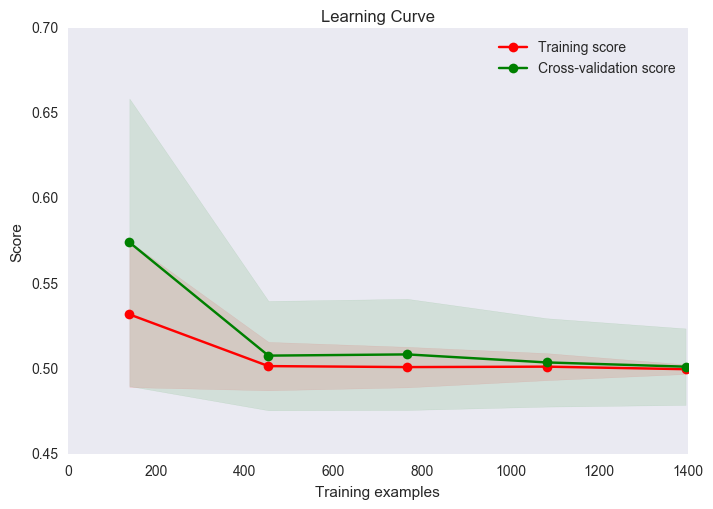

In [19]:
rfc_lc = RandomForestClassifier(n_estimators=2, max_depth=2, min_samples_split=2, max_leaf_nodes=3, random_state=0)

kf_lc = StratifiedKFold(n_splits=20,shuffle=True, random_state=0)
plot_learning_curve(rfc_lc, 'Learning Curve', X_standardized, y, ylim=None, cv=kf_lc, score_metric=bacc_scorer, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

The training score and the cv score are "close" but the scores are not good : 50% on a binary class is just like random... Thus we have here __a high bias__ , we are underfitting. __The model is not complex enough to generalize.__

### Other configurations

Below we can see a very unique behavior in which the training score is below the cross-validation score : which is very unlikely. It shows how sensitive the classifier is to the parameters...

<module 'matplotlib.pyplot' from '/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/matplotlib/pyplot.py'>

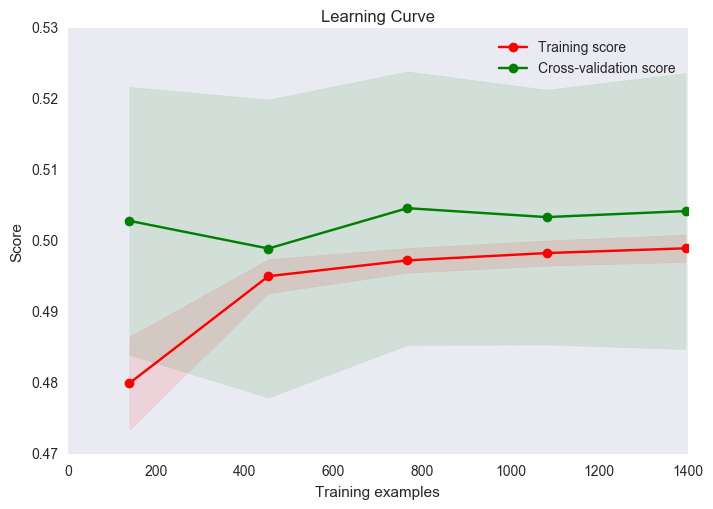

In [20]:
rfc_lc = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_split=10, max_leaf_nodes=3, random_state=0)

kf_lc = StratifiedKFold(n_splits=20,shuffle=True, random_state=0)
plot_learning_curve(rfc_lc, 'Learning Curve', X_standardized, y, ylim=None, cv=kf_lc, score_metric=bacc_scorer, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

---

# See task2-Clustering.ipynb for task 2 answers!